In [1]:
import pandas as pd

df = pd.read_csv('data/assistments2009.csv')

In [2]:
df.head(), df.shape

(   user   item  skill  correct  wins  fails
 0  2099  76429     90        0     0      0
 1  2099  76430     90        1     0      1
 2  2099  76431     90        1     1      1
 3  2099  76432     90        1     2      1
 4  2099  76433     90        0     3      1,
 (278607, 6))

In [3]:
df.groupby('user').size().reset_index().rename(columns={0: 'count'})['count'].sort_values()[-100:]

72      535
443     535
438     537
67      537
462     541
       ... 
82      972
113     972
49      979
75      992
105    1021
Name: count, Length: 100, dtype: int64

In [4]:
import logging
import torch
from torch import nn
from tqdm import trange

# TODO: add \theta and d computed values

class RNN(nn.Module):
    def __init__(self, n_skills, n_items, items_per_skill, hidden_dim=[20, 20], n_layers=[1, 1],
            embed_size=16, n_epochs=100, lr=0.01, batch_size=None, device=None):
        super().__init__()
        self.logger = logging.getLogger(__name__
                                      + '.'
                                      + self.__class__.__name__)
        self.logger.setLevel(logging.DEBUG)
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_epochs = n_epochs
        self.lr = lr
        self.batch_size = batch_size
        # TODO: pass on GPU if available and batch_size allows for it
        self.device = torch.device("cpu") if device is None else device

        self.embed = nn.Embedding(2*n_skills+1, embed_size, padding_idx=0, device=self.device)
        self.rnn = nn.GRU(embed_size, hidden_dim[0], n_layers[0], batch_first=True, device=self.device)
        self.oh_skill = nn.Linear(hidden_dim[0], n_skills, device=self.device)
        #self.skills = [
        #    nn.RNN(n_items+n_skills+1, hidden_dim[1], n_layers[1], batch_first=True)
        #    for _ in range(n_skills)
        #]

    def fit(self, X, Y):
        criterion = torch.nn.CrossEntropyLoss(ignore_index=-100)
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        ls = []
        with trange(self.n_epochs, unit="epoch") as pbar:
            for epoch in pbar:
                optimizer.zero_grad() # Clears existing gradients from previous epoch
                output, hidden = self(X)
                loss = criterion(output.flatten(0, 1), Y.flatten(0, 1))
                loss.backward()
                ls.append(loss.item())
                optimizer.step()

                pbar.set_postfix(loss=loss.item())
        return ls

    def predict(self, X):
        return self.forward(X)[0][:,-1,0].detach().numpy()

    def forward(self, x):
        batch_size = x.size(0)

        hidden = self.init_hidden(batch_size)

        out, hidden[0] = self.rnn(self.embed(x), hidden[0])
        out = self.oh_skill(out)

        return out, hidden

    def init_hidden(self, batch_size):
        hidden = [
            torch.zeros(self.n_layers[0], batch_size, self.hidden_dim[0]) \
                 .to(self.device)
        ]
        return hidden

In [5]:
n_skills = df['skill'].nunique()
n_items = df['item'].nunique()
df["skill_id"] = df["skill"].astype('category')
df["skill_id"] = df["skill_id"].cat.codes
df["item_id"] = df["item"].astype('category')
df["item_id"] = df["item_id"].cat.codes
items_per_skill = df.groupby('skill_id')['item'].nunique()

In [6]:
%%time

seq = [
    [tuple(x) for x in user[['item_id', 'skill_id', 'correct']].to_numpy()]
    for _, user in df.groupby('user')
]
sorted(seq, key=len)[:10]

CPU times: user 2.12 s, sys: 27.4 ms, total: 2.15 s
Wall time: 2.15 s


[[(1121, 0, 0)],
 [(1057, 0, 0)],
 [(1105, 0, 0)],
 [(1049, 0, 0)],
 [(12685, 1, 0)],
 [(12746, 1, 0)],
 [(12873, 5, 0)],
 [(534, 6, 0)],
 [(538, 6, 0)],
 [(2801, 6, 0)]]

In [7]:
len(seq), n_items

(4163, 17716)

In [8]:
%%time
import numpy as np

def oh_encode(x, max_x):
    t = np.zeros(max_x, dtype=int)
    t[x] = 1
    return t

seq_size = 100

seq_oh = []
seq_Y = []
for s in seq:
    for i in range((len(s) + seq_size - 1) // seq_size):
        if len(s) < (i+1)*seq_size:
            seq_oh.append(np.concatenate((np.array([
                skill + n_skills * correct+1
                for item, skill, correct in s[i*seq_size:len(s)]
            ]), np.array([0] * ((i+1)*seq_size-len(s))))))
            seq_Y.append(np.array([skill for _, skill, _ in s[i*seq_size:len(s)]] + [-100] * ((i+1)*seq_size-len(s))))
        else:
            seq_oh.append(np.array([
                skill + n_skills * correct+1
                for item, skill, correct in s[i*seq_size:(i+1)*seq_size]
            ]))
            seq_Y.append(np.array([skill for _, skill, _ in s[i*seq_size:(i+1)*seq_size]]))
seq_oh = np.array(seq_oh)
seq_Y = np.array(seq_Y)
seq_oh.shape, seq_Y.shape

CPU times: user 207 ms, sys: 2.44 ms, total: 209 ms
Wall time: 194 ms


((5831, 100), (5831, 100))

In [9]:
device = torch.device("cpu")
X = torch.from_numpy(seq_oh[:,:-1]).to(device)
Y = torch.from_numpy(seq_Y[:,1:]).to(device)

In [10]:
X.min(), X.max()

(tensor(0), tensor(224))

In [11]:
rnn = RNN(n_skills, n_items, items_per_skill, hidden_dim=[200, 20], n_layers=[2, 1],
            embed_size=16, n_epochs=500, lr=0.01, device=device)

In [12]:
%%time

ls = rnn.fit(X, Y)

  0%|                                                                                                                                                                                | 0/500 [00:00<?, ?epoch/s]/home/akulen/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [1:17:35<00:00,  9.31s/epoch, loss=0.0669]

CPU times: user 7h 30s, sys: 25min 14s, total: 7h 25min 44s
Wall time: 1h 17min 35s


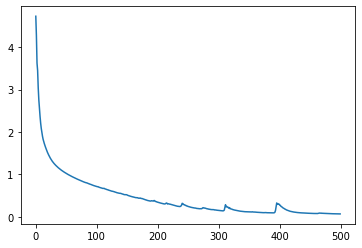

In [13]:
import matplotlib.pyplot as plt

plt.plot(ls)